In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from sys import path
path.insert(0,'..')
from utils import lossprettifier
from Classifier.VGG import *

Using TensorFlow backend.


In [3]:
#x_train = np.load('data1/x_train.npy')
#y_train = np.load('data1/y_train.npy')
#x_test = np.load('data1/x_test.npy')
#y_test = np.load('data1/y_test.npy')

In [4]:
x_train = np.load('preprocessed/x_train_prep.npy')
y_train = np.load('preprocessed/y_train_prep.npy')
x_test = np.load('preprocessed/x_test_prep.npy')
y_test = np.load('preprocessed/y_test_prep.npy')

In [5]:
#x_train = np.load('data1/x_train_prep.npy')
#y_train = np.load('data1/y_train_prep.npy')
#x_test = np.load('data1/x_test_prep.npy')
#y_test = np.load('data1/y_test_prep.npy')

In [6]:
#print(x_train.shape)
#print(x_test.shape)

In [7]:
#print(y_train.shape)
#print(y_test.shape)

In [8]:
#x_train /= 255????

In [9]:
from __future__ import print_function

import numpy as np
from random import shuffle
import time
import csv
from PIL import Image
import os
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras import initializers
from keras.optimizers import SGD
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential,load_model,Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import *
from keras.callbacks import CSVLogger
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import sklearn.metrics as sklm
#import lossprettifier
#from VGG import *

In [10]:
print(tf.__version__)

2.2.1


In [11]:
# for reproducibility
np.random.seed(3768)

# use this environment flag to change which GPU to use 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

#Get TensorFlow session
def get_session(): 
  config = tf.ConfigProto() 
  config.gpu_options.allow_growth = True 
  return tf.Session(config=config) 
  
# One hot encoding of labels 
def dense_to_one_hot(labels_dense,num_clases=3):
  return np.eye(num_clases)[labels_dense]

In [12]:
# Preparing training and test sets
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [13]:
y_train = dense_to_one_hot(y_train,num_clases=3)
y_valid= dense_to_one_hot(y_valid,num_clases=3)

In [14]:
#Image data generation for the training 
datagen = ImageDataGenerator(
               featurewise_center = False, 
               samplewise_center = False,  # set each sample mean to 0
               featurewise_std_normalization = True,  
               samplewise_std_normalization = False)  

datagen.fit(x_train) 
for i in range(len(x_test)):
      x_test[i] = datagen.standardize(x_test[i])

C:\Users\Aleksander Podsiad\.conda\envs\WB_env_tf_1_15_2\lib\site-packages\keras_preprocessing\image\image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [15]:
from keras.callbacks import TensorBoard
from keras.callbacks.callbacks import ModelCheckpoint

In [16]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime

In [17]:
class CustomLearningRateScheduler(keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (10, 0.005),
    (20, 0.001),
    (40, 0.0005),
    (50, 0.0001),
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

In [18]:
# Tensorboard setup
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1, write_graph=True)
earlystop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 50, 
                          verbose = 1, mode = 'auto', restore_best_weights = True) 
lrs = CustomLearningRateScheduler(lr_schedule)


my_callbacks = [tensorboard_callback, earlystop, lrs]

In [19]:
#Defining hyperparameters
batch_Size = 32
steps_Per_Epoch = 32
numEpochs = 60

#Instantating VGG19 model
model = VGG19((224,224,3),3) #VGG19_dense for revised VGG19, VGG19 for VGG19. Please pay attention to VGG16(), chnage the input shape and class number in VGG.py.

model.run_eagerly=True

#Creating an optimizers
adaDelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(optimizer = sgd , loss = 'categorical_crossentropy', metrics = ['accuracy'])      

train_generator = datagen.flow(x_train, y_train, batch_size = batch_Size)
validation_generator = datagen.flow(x_valid, y_valid, batch_size = batch_Size)

# Model training
history = model.fit(
    train_generator,
    steps_per_epoch = steps_Per_Epoch,
    validation_data = validation_generator, 
    validation_steps = 16,
    epochs = numEpochs,
    shuffle = True, 
    verbose = 2, 
    callbacks = my_callbacks)

Epoch 1/60

Epoch 00000: Learning rate is 0.0100.


C:\Users\Aleksander Podsiad\.conda\envs\WB_env_tf_1_15_2\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.932507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - 19s - loss: 1.0999 - accuracy: 0.3408 - val_loss: 1.0536 - val_accuracy: 0.3516
Epoch 2/60

Epoch 00001: Learning rate is 0.0100.
 - 13s - loss: 1.0763 - accuracy: 0.4213 - val_loss: 1.0269 - val_accuracy: 0.4703
Epoch 3/60

Epoch 00002: Learning rate is 0.0100.
 - 15s - loss: 0.9791 - accuracy: 0.5371 - val_loss: 0.9162 - val_accuracy: 0.5447
Epoch 4/60

Epoch 00003: Learning rate is 0.0100.
 - 15s - loss: 0.8770 - accuracy: 0.6016 - val_loss: 0.7687 - val_accuracy: 0.6314
Epoch 5/60

Epoch 00004: Learning rate is 0.0100.
 - 15s - loss: 0.8456 - accuracy: 0.6221 - val_loss: 0.9383 - val_accuracy: 0.6801
Epoch 6/60

Epoch 00005: Learning rate is 0.0100.
 - 15s - loss: 0.8447 - accuracy: 0.6484 - val_loss: 0.8501 - val_accuracy: 0.7073
Epoch 7/60

Epoch 00006: Learning rate is 0.0100.
 - 14s - loss: 0.7648 - accuracy: 0.6683 - val_loss: 0.8191 - val_accuracy: 0.6907
Epoch 8/60

Epoch 00007: Learning rate is 0.0100.
 - 15s - loss: 0.7627 - accuracy: 0.6719 - val_loss: 0.5986 - val_acc

In [20]:
modelPath = "VGG19_COVID19_tboard.h5"
resultPath = 'VGG19_COVID19_tboard.txt'

In [21]:
del x_train # clear memory

In [22]:
y_test_oh = dense_to_one_hot(y_test, num_clases=3)

# visualizing losses and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']

#Observing the losses but can be commented out as it's not mandatory 
reporter = lossprettifier.LossPrettifier(show_percentage=True)

for i in range(numEpochs-1):
    reporter(epoch=i, LossA = train_loss[i], LossAB = val_loss[i])

# Model evaluation 
score, acc = model.evaluate(x_test, y_test_oh, batch_size=batch_Size)
print("Accuracy:", acc)

#if acc>0.675:
model.save_weights(modelPath)

Epoch     0 | LossA: 1.10(+0.00%) 	| LossAB: 1.05(+0.00%) 	
Epoch     1 | LossA: 1.08(-1.99%) ▼	| LossAB: 1.03(-2.54%) ▼	
Epoch     2 | LossA: 0.98(-9.18%) ▼	| LossAB: 0.92(-10.78%) ▼	
Epoch     3 | LossA: 0.88(-10.58%) ▼	| LossAB: 0.77(-16.10%) ▼	
Epoch     4 | LossA: 0.85(-3.42%) ▼	| LossAB: 0.94(+22.06%) ▲	
Epoch     5 | LossA: 0.84(-0.10%) ▼	| LossAB: 0.85(-9.40%) ▼	
Epoch     6 | LossA: 0.77(-8.93%) ▼	| LossAB: 0.82(-3.65%) ▼	
Epoch     7 | LossA: 0.76(-0.86%) ▼	| LossAB: 0.60(-26.92%) ▼	
Epoch     8 | LossA: 0.74(-2.74%) ▼	| LossAB: 0.89(+48.32%) ▲	
Epoch     9 | LossA: 0.75(+0.74%) ▲	| LossAB: 0.65(-27.34%) ▼	
Epoch    10 | LossA: 0.70(-6.81%) ▼	| LossAB: 0.63(-3.09%) ▼	
Epoch    11 | LossA: 0.70(-0.03%) ▼	| LossAB: 0.77(+23.48%) ▲	
Epoch    12 | LossA: 0.68(-2.72%) ▼	| LossAB: 0.63(-18.34%) ▼	
Epoch    13 | LossA: 0.66(-3.13%) ▼	| LossAB: 0.62(-1.53%) ▼	
Epoch    14 | LossA: 0.63(-3.59%) ▼	| LossAB: 0.47(-23.68%) ▼	
Epoch    15 | LossA: 0.68(+6.77%) ▲	| LossAB: 0.75(+57.96%) ▲	

In [23]:
y_pred = model.predict(x_test)
y_pred = y_pred.reshape(len(y_test), 3)
y_pred = np.argmax(y_pred, axis=1)

# Writing results on file
#f = open(resultPath,'a') #create classification report
#f.write(classification_report(y_test, y_pred))
#f.write(str(sklm.cohen_kappa_score(y_test, y_pred))+","+str(acc)+","+str(score)+"\n")

#f.close()
#Print class-wise classification metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       100
           1       0.83      0.85      0.84       100
           2       0.73      0.69      0.71       100

    accuracy                           0.77       300
   macro avg       0.77      0.77      0.77       300
weighted avg       0.77      0.77      0.77       300



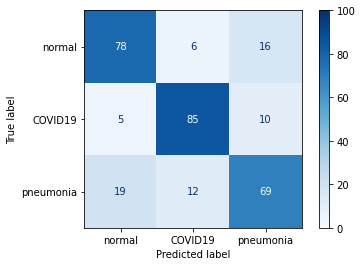

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['normal', 'COVID19', 'pneumonia']))
disp.plot(cmap='Blues') 
disp.ax_.get_images()[0].set_clim(0, 100)

In [25]:
vggModel = VGG19((224,224,3),3, False) #set up model architecture

#vggModel.summary()
vggModel.load_weights(modelPath) #load weights

y_pred = vggModel.predict(x_test)
y_pred = y_pred.reshape(len(y_test), 3)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       100
           1       0.83      0.85      0.84       100
           2       0.73      0.69      0.71       100

    accuracy                           0.77       300
   macro avg       0.77      0.77      0.77       300
weighted avg       0.77      0.77      0.77       300



In [26]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 19524), started 16:28:26 ago. (Use '!kill 19524' to kill it.)